# IMDb Sentiment Analysis

In [59]:
# Importing relevant libraries:

import pandas as pd
import re

from bs4 import BeautifulSoup
from string import punctuation

# Sci-Kit Learn:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier

# NLTK:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [29]:
# Reading the IMDb data
imdb = pd.read_csv(r"C:\Users\sando\OneDrive\Escritorio\Personal Projects\IMDB Sentiment Analysis\dataset\imdb_reviews.csv", encoding = 'UTF-8')

# Exploratory Data Analysis (EDA)

In [30]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [31]:
# Converting the columsn to string
imdb['review'] = imdb['review'].astype(str)
imdb['sentiment'] = imdb['sentiment'].astype(str)

In [32]:
# Checking if our data is balanced
imdb['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

# Labeling the Sentiment

In [33]:
# Labeling the sentiment data:
lb = LabelBinarizer()
imdb['sentiment'] = lb.fit_transform(imdb['sentiment'])

In [34]:
imdb['sentiment'].value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

# Text Normalization

In [35]:
# Checking for NAN values:
imdb['review'].isna().value_counts()

review
False    50000
Name: count, dtype: int64

### Removing HTML Tags

In [36]:
# Removing the html strips:
def strip_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# # Applying our function:
# imdb['review'] = imdb['review'].apply(strip_html_tags)
# imdb['review']

### Removing Stop Words, Punctuation, and Numbers

In [37]:
stop_words = stopwords.words('english')

# Cleaning up the text:
def clean_text(text):
    # Tokenizing the text
    words = word_tokenize(text)
    # Removing stop words, punctuation, and numbers 
    processed_words = [w for w in words if w.lower() not in stop_words and w not in punctuation and not w.isdigit()]
    processed_words = ' '.join(processed_words)
    return processed_words 

# imdb['review'] = imdb['review'].apply(clean_text)
# print(imdb['review']) 

### Removing Special Charcaters

In [38]:
# Removing special characters:
def remove_special_characters(text, remove_digits = False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

# imdb['review'] = imdb['review'].apply(remove_special_characters) 
# imdb['review']

### Removing Redundant Whitespace

In [39]:
# Removing the redundant whitespaces:
def remove_redundant_whitespaces(text):
    text = re.sub(pattern= r'\s+', repl= ' ', string= text)
    return text.strip()

# imdb['review'] = imdb['review'].apply(remove_redundant_whitespaces)
# print(imdb['review'])

### Text Stemming

In [40]:
# Stemming the text:
def simple_stemmer(text):
    stemmer = PorterStemmer()
    words = text.split()
    stemmed_text = ' '.join([stemmer.stem(word) for word in words])
    return stemmed_text

# imdb['review'] = imdb['review'].apply(simple_stemmer)
# print(imdb['review'])

### Text Normalization Pipeline

In [41]:
def normalize_text(text):
    # Removing the HTML tags:
    normalized_text = strip_html_tags(text)

    # Removing stop words, punctuation, and numbers
    normalized_text = clean_text(normalized_text)

    # Removing special characters:
    normalized_text = remove_special_characters(normalized_text, remove_digits = False)

    # Removing the redundant whitespaces:
    normalized_text = remove_redundant_whitespaces(normalized_text)

    # Stemmatization:
    normalized_text = simple_stemmer(normalized_text)
    
    return normalized_text

imdb['review'] = imdb['review'].apply(normalize_text)
print(imdb['review'])

C:\Users\sando\AppData\Local\Temp\ipykernel_13392\1919239933.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


0        one review mention watch oz episod ll hook rig...
1        wonder littl product film techniqu unassum old...
2        thought wonder way spend time hot summer weeke...
3        basic s famili littl boy jake think s zombi cl...
4        petter mattei s love time money visual stun fi...
                               ...                        
49995    thought movi right good job nt creativ origin ...
49996    bad plot bad dialogu bad act idiot direct anno...
49997    cathol taught parochi elementari school nun ta...
49998    m go disagre previou comment side maltin one s...
49999    one expect star trek movi high art fan expect ...
Name: review, Length: 50000, dtype: object


# Splitting the Data Set

In [42]:
# Splitting the dataset using sklearn
X = imdb['review'] # features
y = imdb['sentiment'] # target labels

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.3)

print('x_train:', x_train.shape[0])
print('x_test:', x_test.shape[0])
print('y_train:', y_train.shape[0])
print('y_test:', y_test.shape[0])

x_train: 35000
x_test: 15000
y_train: 35000
y_test: 15000


# Model Fitting:

### Feature Engineering: Bag of Words Model

In [43]:
# Count vectorizer for bag of words:
cv = CountVectorizer(min_df= 0.0, # lower threshold
                     max_df= 1.0, # upper threshold
                     binary= False, 
                     ngram_range= (1,3)) # ngram_range(1, 3) includes more context
# Transforming the training set:
cv_train_reviews = cv.fit_transform(x_train)
#Tranforming the testing set:
cv_test_reviews = cv.transform(x_test)

print('BoW_cv_train:', cv_train_reviews.shape)
print('BoW_cv_test:', cv_test_reviews.shape)
vocab = cv.get_feature_names_out()

BoW_cv_train: (35000, 5969179)
BoW_cv_test: (15000, 5969179)


### Feature Engineering: Term Frequency-Inverse Document Frequency Model (TFIDF)

In [44]:
tv = TfidfVectorizer(min_df= 0.0, max_df= 1.0, use_idf= True, ngram_range=(1,3))
tv_train_reviews = tv.fit_transform(x_train)
tv_test_reviews = tv.transform(x_test)

print('Tfidf_train:', tv_train_reviews.shape)
print('Tfidf_test:', tv_test_reviews.shape)

Tfidf_train: (35000, 5969179)
Tfidf_test: (15000, 5969179)


### Fitting the Logistic Regression Model 

In [45]:
# Training the logistic regression model:
lr = LogisticRegression(penalty= 'l2', #* L2 Regularization (penalizes the sum of the squared values)
                        max_iter= 500, #* maximum number of iterations
                        C=1, #* regularization strength
                        random_state= 42)

# Fitting the model for BoW features:
#* variable_name = lr.fit(x_train, y_train)
lr_bow = lr.fit(cv_train_reviews, y_train)
print('lr_bow:', lr_bow)

# Fitting the model for TFIDF feature:
#* variable_name = lr.fit(x_train, y_train)
lr_tfidf = lr.fit(tv_train_reviews, y_train)
print('lr_tfidf:', lr_tfidf)

lr_bow: LogisticRegression(C=1, max_iter=500, random_state=42)
lr_tfidf: LogisticRegression(C=1, max_iter=500, random_state=42)


# Model Testing

### Making Our Predictions

In [46]:
# Predicting using BoW model:
lr_bow_predictions = lr.predict(cv_test_reviews)
print(lr_bow_predictions)
# Predicting using the TFIDF model:
lr_tfidf_predictions = lr.predict(tv_test_reviews)
print(lr_tfidf_predictions)

[0 0 0 ... 1 0 0]
[0 0 0 ... 1 0 0]


### Assessing the Accuracy of the Model

In [50]:
# Accuracy score for the bag of words features:
#* accuracy = accuracy_score(true_labels, predicted_labels)
lr_bow_score = accuracy_score(y_test, lr_bow_predictions)
print('lr_bow_score:', lr_bow_score)
# Accuracy score for the tfidf features:
#* accuracy = accuracy_score(true_labels, predicted_labels)
lr_tfidf_score = accuracy_score(y_test, lr_tfidf_predictions)
print('lr_tfidf_score:', lr_tfidf_score)

lr_bow_score: 0.8475333333333334
lr_tfidf_score: 0.879


<span style="color: rgb(50, 98, 168);">Question: Why is my accuracy significantly higher than the example notebook I used?</span>

### Printing the Classification Report:

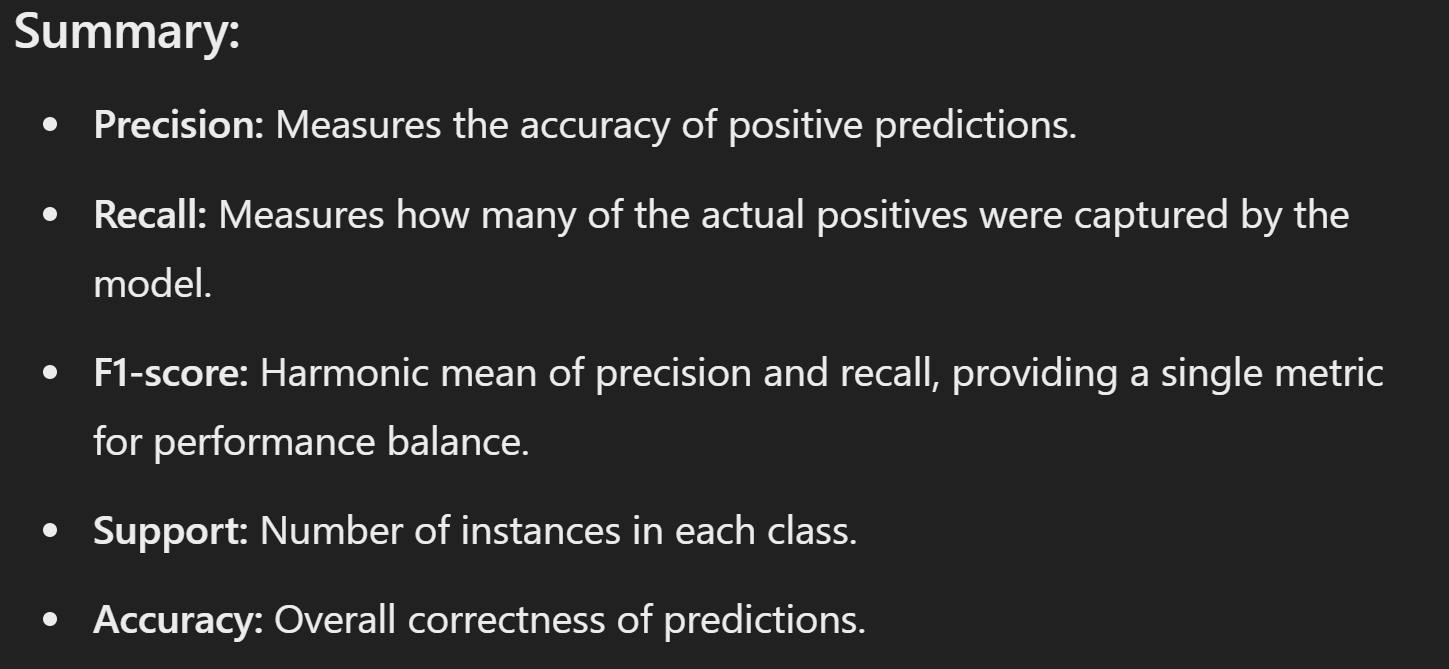

In [57]:
# Defining our target names:
target_names = ['Postive', 'Negative']

# Classification report for the bag of words model:
lr_bow_report =  classification_report(y_test, lr_bow_predictions, target_names = target_names)
print('bow_report:', lr_bow_report)
# Classification report for the tfidf model:
lr_tfdif_report =  classification_report(y_test, lr_tfidf_predictions, target_names = ['Postive', 'Negative'])
print('tfdif_report:', lr_tfdif_report)

bow_report:               precision    recall  f1-score   support

     Postive       0.83      0.88      0.85      7523
    Negative       0.87      0.81      0.84      7477

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000

tfdif_report:               precision    recall  f1-score   support

     Postive       0.89      0.87      0.88      7523
    Negative       0.87      0.89      0.88      7477

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



### Confusion Matrix:

In [63]:
# Confusion matrix for bow:
bow_confusion_matrix = confusion_matrix(y_test, lr_bow_predictions, labels= [0, 1])
print('bow_confusion_matrix: \n\n', bow_confusion_matrix, '\n')
# Confusion matrix for tfidf:
tfidf_confusion_matrix = confusion_matrix(y_test, lr_bow_predictions, labels= [0, 1])
print('tfidf_confusion_matrix: \n\n', tfidf_confusion_matrix)

bow_confusion_matrix: 

 [[6622  901]
 [1386 6091]] 

tfidf_confusion_matrix: 

 [[6622  901]
 [1386 6091]]


# Stochastic Gradient Descent

# Multinomial Naive Bayes